In [7]:
# imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.io import imread
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import shuffle
from skimage.transform import resize
import tensorflow as tf
import keras
from tensorflow.keras import layers
from keras.losses import SparseCategoricalCrossentropy
from keras.layers import Dense, Conv2D, MaxPool2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import random

In [56]:
# Adapting train and test functions from tutorial to fit this dataset
# Including image resize, shuffle and splitting test as well

train_directory = './train/'
test_directory = './test/'
valid_directory = './valid/'

def get_classes():
    classes = []
    birds = os.listdir(train_directory)
    selections = random.sample(range(len(birds)), 15)

    for s in selections:
        classes.append(birds[s])
    return classes


def create_training_data():
    training_data = []
    X_train = []
    y_train = []
    for c in classes:
        image_folder = os.path.join(train_directory, c)
        for i in os.listdir(image_folder):
            image_path = os.path.join(image_folder, i)
            img = imread(image_path, as_gray=False)
            img = resize(img, (150, 150, 3), anti_aliasing=True)
            # I tested it and dividing the image by 255.0 after resizing completely kills the image
            class_value = classes.index(c)
            training_data.append([img, class_value])
    
    training_data = shuffle(training_data)
    
    for attr, lbl in training_data:
        X_train.append(attr)
        y_train.append(lbl)
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    return X_train, y_train

def create_test_data():
    test_data = []
    X_test = []
    y_test = []
    for c in classes:
        image_folder = os.path.join(test_directory, c)
        for i in os.listdir(image_folder):
            image_path = os.path.join(image_folder, i)
            img = imread(image_path, as_gray=False)
            img = resize(img, (150, 150, 3), anti_aliasing=True)
            class_value = classes.index(c)
            test_data.append([img, class_value])
    
    test_data = shuffle(test_data)
    
    for attr, lbl in test_data:
        X_test.append(attr)
        y_test.append(lbl)
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    return X_test, y_test

In [53]:
classes = get_classes()
classes

['SNOWY EGRET',
 'GAMBELS QUAIL',
 'BLUE THROATED TOUCANET',
 'GUINEAFOWL',
 'BANDED STILT',
 'ORANGE BRESTED BUNTING',
 'JAPANESE ROBIN',
 'PARADISE TANAGER',
 'ENGGANO MYNA',
 'BELTED KINGFISHER',
 'OSTRICH',
 'MYNA',
 'NORTHERN GOSHAWK',
 'ANDEAN SISKIN',
 'ANNAS HUMMINGBIRD']

In [57]:
X_train, y_train = create_training_data()
print(f"Training data shape: {X_train.shape}")
print(f"Training data length: {len(X_train)}")

X_test, y_test = create_test_data()
print(f"Testing data shape: {X_test.shape}")
print(f"Testing data length: {len(X_test)}")


Training data shape: (2082, 150, 150, 3)
Training data length: 2082
Testing data shape: (75, 150, 150, 3)
Testing data length: 75


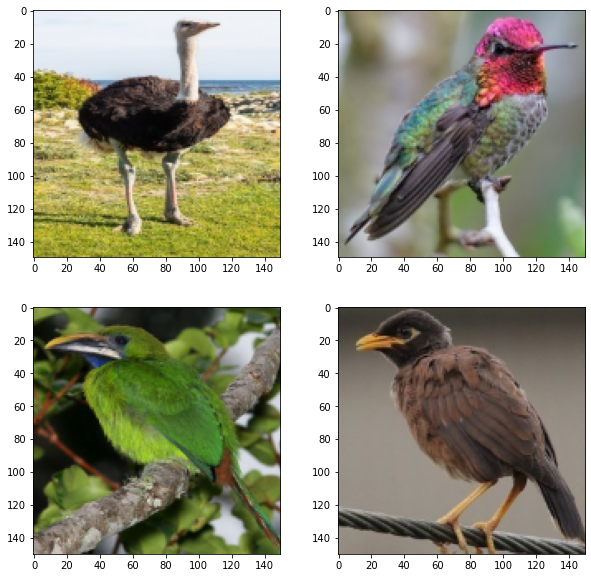

In [58]:
i = 99
plt.figure(figsize=(10,10))
plt.subplot(221), plt.imshow(X_train[i])
plt.subplot(222), plt.imshow(X_train[i+25])
plt.subplot(223), plt.imshow(X_train[i+50])
plt.subplot(224), plt.imshow(X_train[i+75])
plt.show();

In [59]:
X_train = tf.convert_to_tensor(X_train)
y_train = tf.convert_to_tensor(y_train)
X_test = tf.convert_to_tensor(X_test)
y_test = tf.convert_to_tensor(y_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2082, 150, 150, 3) (2082,)
(75, 150, 150, 3) (75,)


In [60]:
model = keras.Sequential()

# Draws samples from a uniform distribution within [-limit, limit], 
# where limit = sqrt(6 / fan_in) (fan_in is the number of input units in the weight tensor)

model.add(Conv2D(32,(3,3), input_shape=(150,150,3), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())

model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))

# Apply Dropout to reduce overfit 

model.add(Dropout(rate=0.5))

#Apply Batch Normalization to standardize input and reduce impact of random weights

model.add(BatchNormalization())

model.add(Dense(15, activation='softmax'))



In [61]:
model.compile(loss=SparseCategoricalCrossentropy(from_logits=True),optimizer='adam', metrics=['accuracy'])

In [62]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 17, 17, 64)      

In [63]:
# Early Stopping to find optimal number of epochs to reduce loss in validation dataset
es = EarlyStopping(monitor='val_loss', patience=5)

In [64]:
epochs = 100

history = model.fit(X_train, y_train, batch_size=32, validation_split=0.2, epochs=epochs, callbacks=[es])

Epoch 1/100


c:\Users\matth\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


53/53 [==============================] - 30s 537ms/step - loss: 2.6567 - accuracy: 0.1514 - val_loss: 3.3079 - val_accuracy: 0.0983
Epoch 2/100
53/53 [==============================] - 27s 515ms/step - loss: 2.2621 - accuracy: 0.2655 - val_loss: 2.2831 - val_accuracy: 0.3022
Epoch 3/100
53/53 [==============================] - 28s 522ms/step - loss: 1.9063 - accuracy: 0.4066 - val_loss: 1.7422 - val_accuracy: 0.5588
Epoch 4/100
53/53 [==============================] - 28s 522ms/step - loss: 1.5210 - accuracy: 0.5586 - val_loss: 1.4289 - val_accuracy: 0.6283
Epoch 5/100
53/53 [==============================] - 27s 514ms/step - loss: 1.3059 - accuracy: 0.6444 - val_loss: 1.2760 - val_accuracy: 0.6619
Epoch 6/100
53/53 [==============================] - 27s 517ms/step - loss: 1.0764 - accuracy: 0.7111 - val_loss: 1.1326 - val_accuracy: 0.7554
Epoch 7/100
53/53 [==============================] - 27s 514ms/step - loss: 0.9078 - accuracy: 0.7670 - val_loss: 0.9788 - val_accuracy: 0.7914
Epoc

In [65]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.1523677259683609
Test accuracy: 0.9466666579246521


In [66]:
model.save('model_better.h5')

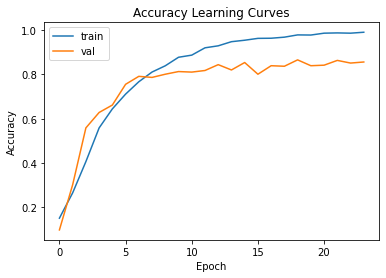

In [67]:
# Plotting accuracy function across different epochs

plt.title('Accuracy Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.show();


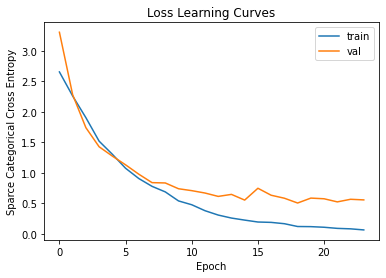

In [68]:
plt.title('Loss Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Sparce Categorical Cross Entropy')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show();

In [69]:
predictions = model.predict(X_test)
preds = [np.argmax(p) for p in predictions]

3/3 [==============================] - 0s 91ms/step


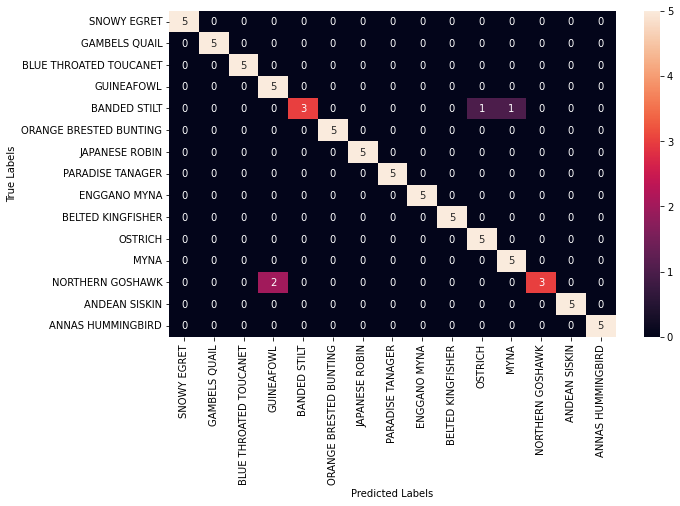

In [70]:
fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(confusion_matrix(y_test, preds), annot=True, fmt='d', ax=ax)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels');
locs, labels = plt.xticks()
plt.xticks(ticks=locs, labels=classes, rotation = 'vertical')
plt.yticks(ticks=locs, labels=classes, rotation = 'horizontal')
plt.show();


In [71]:
print(classification_report(y_test,preds,digits=14))

                precision    recall  f1-score   support

             0  1.00000000000000 1.00000000000000 1.00000000000000         5
             1  1.00000000000000 1.00000000000000 1.00000000000000         5
             2  1.00000000000000 1.00000000000000 1.00000000000000         5
             3  0.71428571428571 1.00000000000000 0.83333333333333         5
             4  1.00000000000000 0.60000000000000 0.75000000000000         5
             5  1.00000000000000 1.00000000000000 1.00000000000000         5
             6  1.00000000000000 1.00000000000000 1.00000000000000         5
             7  1.00000000000000 1.00000000000000 1.00000000000000         5
             8  1.00000000000000 1.00000000000000 1.00000000000000         5
             9  1.00000000000000 1.00000000000000 1.00000000000000         5
            10  0.83333333333333 1.00000000000000 0.90909090909091         5
            11  0.83333333333333 1.00000000000000 0.90909090909091         5
            12  1.0

In [72]:
def create_validation_data():
    valid_data = []
    data = []
    target = []
    for c in classes:
        image_folder = os.path.join(valid_directory, c)
        for i in os.listdir(image_folder):
            image_path = os.path.join(image_folder, i)
            img = imread(image_path, as_gray=False)
            img = resize(img, (150, 150, 3), anti_aliasing=True)
            class_value = classes.index(c)
            valid_data.append([img, class_value])
    
    valid_data = shuffle(valid_data)

    for attr, lbl in valid_data:
        data.append(attr)
        target.append(lbl)
    data = np.array(data)
    target = np.array(target)

    return data, target

In [73]:
data, target = create_validation_data()
print(f'Data shape: {data.shape}')
print(f'Data length: {len(data)}')

Data shape: (75, 150, 150, 3)
Data length: 75


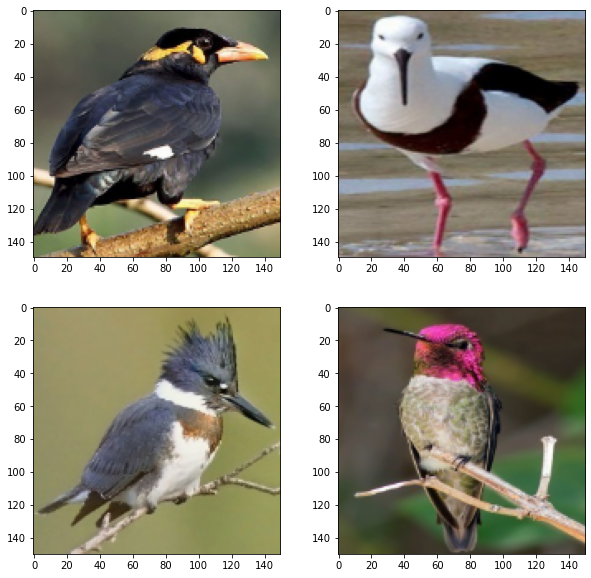

In [74]:
i = 3
plt.figure(figsize=(10,10))
plt.subplot(221), plt.imshow(data[i])
plt.subplot(222), plt.imshow(data[i+10])
plt.subplot(223), plt.imshow(data[i+20])
plt.subplot(224), plt.imshow(data[i+30])
plt.show();

In [75]:
predictions = model.predict(data)
preds = [np.argmax(p) for p in predictions]

3/3 [==============================] - 0s 89ms/step


In [76]:
accuracy_score(target, preds)

0.8933333333333333

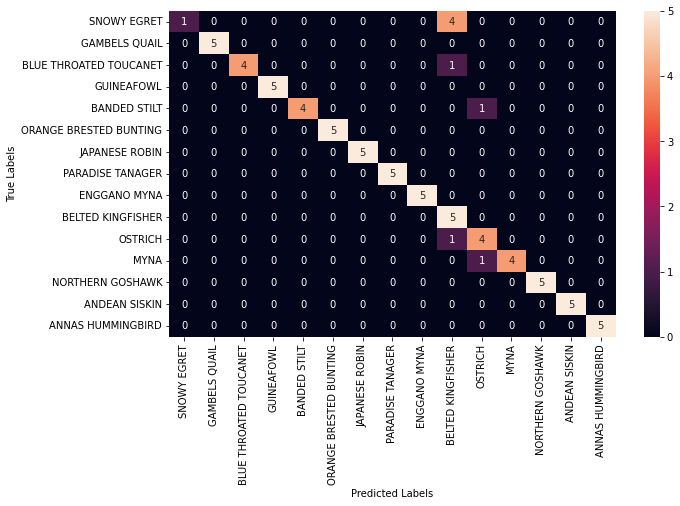

In [77]:
fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(confusion_matrix(target, preds), annot=True, fmt='d', ax=ax)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels');
locs, labels = plt.xticks()
plt.xticks(ticks=locs, labels=classes, rotation = 'vertical')
plt.yticks(ticks=locs, labels=classes, rotation = 'horizontal')
plt.show();

# The only problematic class here is the Snowy Egret, which worked well on the test data but not the validation data for some reason.

In [78]:
print(classification_report(target,preds,digits=14))

                precision    recall  f1-score   support

             0  1.00000000000000 0.20000000000000 0.33333333333333         5
             1  1.00000000000000 1.00000000000000 1.00000000000000         5
             2  1.00000000000000 0.80000000000000 0.88888888888889         5
             3  1.00000000000000 1.00000000000000 1.00000000000000         5
             4  1.00000000000000 0.80000000000000 0.88888888888889         5
             5  1.00000000000000 1.00000000000000 1.00000000000000         5
             6  1.00000000000000 1.00000000000000 1.00000000000000         5
             7  1.00000000000000 1.00000000000000 1.00000000000000         5
             8  1.00000000000000 1.00000000000000 1.00000000000000         5
             9  0.45454545454545 1.00000000000000 0.62500000000000         5
            10  0.66666666666667 0.80000000000000 0.72727272727273         5
            11  1.00000000000000 0.80000000000000 0.88888888888889         5
            12  1.0